In [3]:
from google.colab import files
uploaded = files.upload()
import os
print("Uploaded files:", os.listdir())

Saving labeled_sms_dataset_BALANCED.csv to labeled_sms_dataset_BALANCED.csv
Uploaded files: ['.config', 'labeled_sms_dataset_BALANCED.csv', 'sample_data']


In [4]:
import pandas as pd
df = pd.read_csv("labeled_sms_dataset_BALANCED.csv")
print(f"Dataset Shape: {df.shape}")
print("\nCategory Distribution:")
print(df['category'].value_counts())
print("\nFirst 5 Rows:")
print(df.head())

Dataset Shape: (12030, 3)

Category Distribution:
category
Spam             4010
Promotional      4010
Transactional    4010
Name: count, dtype: int64

First 5 Rows:
                                             message  \
0  Reset your password now at https://get-rich-fa...   
1   Find your perfect gift at https://amazon.in/sale   
2  Reset your password now at https://iphone14win...   
3   Your OTP is 638770. Do not share it with anyone.   
4  Your package with tracking ID 172940 has been ...   

                                     cleaned_message       category  
0  reset your password now at https://get-rich-fa...           Spam  
1   find your perfect gift at https://amazon.in/sale    Promotional  
2  reset your password now at https://iphone14win...           Spam  
3   your otp is 638770. do not share it with anyone.  Transactional  
4  your package with tracking id 172940 has been ...  Transactional  


In [5]:
from sklearn.model_selection import train_test_split

# Features and labels
X = df['cleaned_message']
y = df['category']

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensures balanced split per class
)

print(f"Train size: {len(X_train)}")
print(f"Test size : {len(X_test)}")

Train size: 9624
Test size : 2406


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use TF-IDF to convert text to numbers
vectorizer = TfidfVectorizer(
    max_features=5000,           # Limit vocabulary size
    ngram_range=(1, 2),          # Use single words and pairs
    stop_words='english',        # Remove common words
    lowercase=False              # Already lowercase
)

# Fit on training data, transform both
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Vectorized: {X_train_vec.shape[1]} features")

Vectorized: 5000 features


In [7]:
from sklearn.linear_model import LogisticRegression

# Train a fast, lightweight model
model = LogisticRegression(
    max_iter=1000,
    random_state=42
)

# Fit on training data
print("Training model...")
model.fit(X_train_vec, y_train)
print("Model trained!")

Training model...
Model trained!


In [8]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Predict on test set
y_pred = model.predict(X_test_vec)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f" Accuracy  : {accuracy:.3f}")
print(f" Precision : {precision:.3f}")
print(f" Recall    : {recall:.3f}")
print(f" F1-Score  : {f1:.3f}")

# Detailed report
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

 Accuracy  : 1.000
 Precision : 1.000
 Recall    : 1.000
 F1-Score  : 1.000

 Classification Report:
               precision    recall  f1-score   support

  Promotional       1.00      1.00      1.00       802
         Spam       1.00      1.00      1.00       802
Transactional       1.00      1.00      1.00       802

     accuracy                           1.00      2406
    macro avg       1.00      1.00      1.00      2406
 weighted avg       1.00      1.00      1.00      2406



In [ ]:
# Train on X_train, y_train
model.fit(X_train_vec, y_train)

# Evaluate on X_test, y_test
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

  Promotional       1.00      1.00      1.00       802
         Spam       1.00      1.00      1.00       802
Transactional       1.00      1.00      1.00       802

     accuracy                           1.00      2406
    macro avg       1.00      1.00      1.00      2406
 weighted avg       1.00      1.00      1.00      2406



In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train_vec, y_train, cv=5)
print(f"Cross-Validation Scores: {scores}")
print(f"Mean CV Score: {scores.mean():.3f}")

Cross-Validation Scores: [0.9974026 1.        1.        1.        1.       ]
Mean CV Score: 0.999


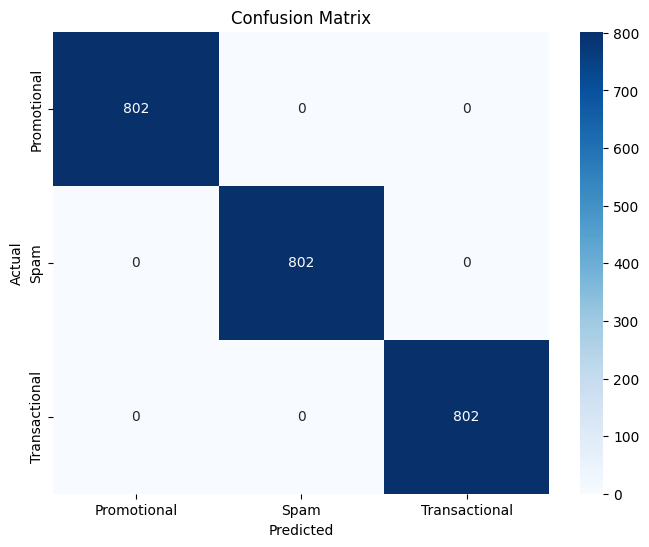

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
def predict_single_message(text):
    # Clean the message (same as before)
    cleaned = re.sub(r'\s+', ' ', text.lower().strip())

    # Vectorize
    vec = vectorizer.transform([cleaned])

    # Predict
    pred = model.predict(vec)[0]
    proba = model.predict_proba(vec)[0]
    confidence = max(proba)

    return pred, confidence

# Test on sample messages
test_messages = [
    "Your OTP is 123456. Do not share it with anyone.",
    "You've won a prize! Click https://fakewebsite.com ",
    "Check out our sale at https://trip.com "
]

import re

for msg in test_messages:
    pred, conf = predict_single_message(msg)
    print(f" '{msg}'")
    print(f"   → {pred} (confidence: {conf:.2f})\n")

 'Your OTP is 123456. Do not share it with anyone.'
   → Transactional (confidence: 1.00)

 'You've won a prize! Click https://fakewebsite.com '
   → Spam (confidence: 0.99)

 'Check out our sale at https://trip.com '
   → Promotional (confidence: 0.97)



In [11]:
import time

# Speed test: Time one prediction
start = time.time()
_, _ = predict_single_message("Your OTP is 9876. Do not share it.")
latency = (time.time() - start) * 1000  # ms

print(f"Inference Time: {latency:.2f} ms")
print(" Passed!" if latency < 100 else "⚠️ Too slow!")

Inference Time: 2.71 ms
 Passed!


In [12]:
import joblib

# Create models folder
!mkdir -p models

# Save trained model and vectorizer
joblib.dump(model, 'models/spam_model.pkl')
joblib.dump(vectorizer, 'models/vectorizer.pkl')

print("Model and vectorizer saved!")

# Download them for later use
files.download('models/spam_model.pkl')
files.download('models/vectorizer.pkl')

Model and vectorizer saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip freeze | grep -E 'fastapi|uvicorn|scikit-learn|pandas|joblib|numpy' > requirements.txt